## ARCH
### Auto Regressive Conditional Heteroeskedacity
[Notes](https://learn.london.ac.uk/pluginfile.php/265820/mod_resource/content/4/Topic%208%20Lecture%203%20Arch%20notes.pdf)



Trying to predict the squares of the errors

In [39]:
import pandas as pd
import yfinance
import matplotlib.pyplot as plt
import statsmodels.api as sm
tesla_frame = yfinance.Ticker('TSLA').history(start='2020-01-01', end='2022-01-01', interval='1d').reset_index()['Close'].to_frame()

plt.rcParams['figure.figsize'] = [16, 8]
series = tesla_frame['Close']
ar_deg = 4

model = sm.tsa.AutoReg(series, lags=ar_deg, trend='n').fit()
prediction1 = model.predict()
tesla_frame['Prediction'] = prediction1
tesla_frame[10:20]

,Close,Prediction
10,34.232666,34.845114
11,34.033333,34.330911
12,36.480000,34.020878
13,37.970669,36.507407
14,38.146667,38.065959
15,37.654667,38.391382
16,37.201332,37.824353
17,37.793331,37.280605
18,38.732666,37.826047
19,42.720669,38.785557


<AxesSubplot:>

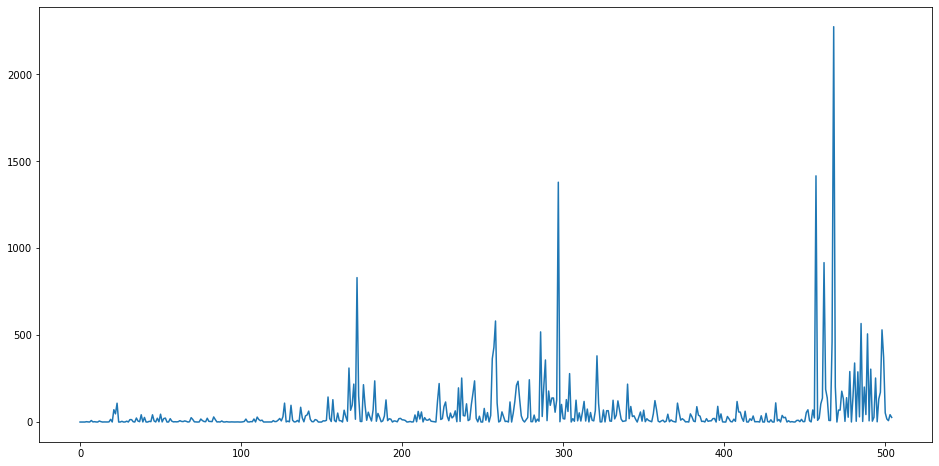

In [40]:
error_sq = (series - prediction1) ** 2
error_sq[error_sq.isna()] = 0
error_sq.plot()

Predict value of the square of the error using ARCH model  

Linear sum of previous square errors with a constant terms  
Biased AR model on the error squared estimates  

**AR** - usual  
**Conditional**: heteroeskedacity is not constant  
**Heteroskedasticy**: different - means that the variance changes



Use the inbuilt ARIMA code, to compute ARCH.   
In this example, we will use an ARCH(5) model.   
The data is the error_sq we computed above.     
Since this is a biased model (i.e. with a constant term) we will have the parameter ```trend='c'```

In [41]:
arch_deg = 4
# trend='c' means biased model
arch_model = sm.tsa.AutoReg(error_sq, lags=arch_deg, trend='c').fit()
error_prediction_sq = arch_model.predict()
error_prediction_sq[10:20]

10    42.028685
11    42.514480
12    41.770396
13    42.768053
14    42.391401
15    41.804614
16    42.215446
17    41.932224
18    41.742937
19    41.862603
dtype: float64

<AxesSubplot:>

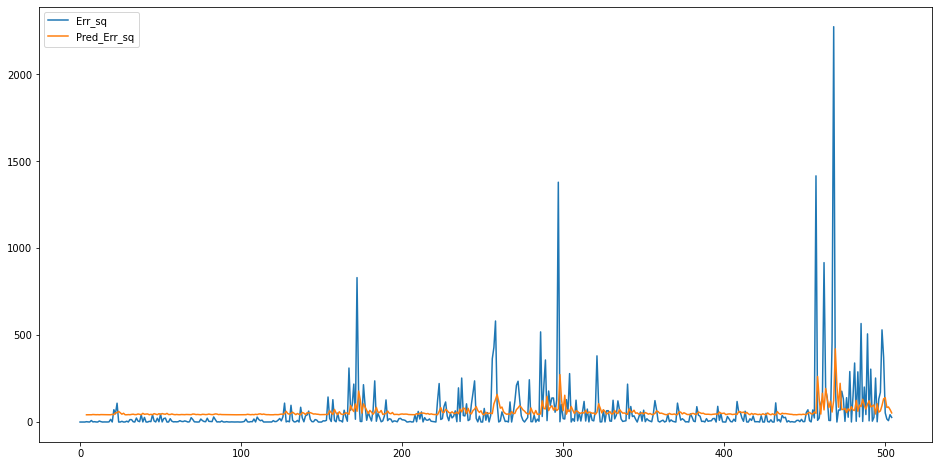

In [42]:
# make new frame of the error squared and prediction
tesla_errorsq_frame = pd.DataFrame(columns = ['Err_sq','Pred_Err_sq'])
tesla_errorsq_frame ['Err_sq']= error_sq
tesla_errorsq_frame['Pred_Err_sq'] = error_prediction_sq
tesla_errorsq_frame.plot()

As before, we are going to use the error prediction as the standard deviation of our predictions.  

We will have a one standard deviation envelope around the prediction.   
The Lower Bound will be the prediction - the error prediction.  
The Upper Bound will be the prediction + the error prediction.   
Let's make another dataframe. This one of the prediction envelopes.



In [43]:
import numpy as np
error_prediction = np.sqrt(arch_model.predict())
tesla_envelope_df = tesla_frame['Close'].to_frame()
tesla_envelope_df ['Lower'] = prediction1 - error_prediction
tesla_envelope_df ['Upper'] = prediction1 + error_prediction
tesla_envelope_df [100:110]

,Close,Lower,Upper
100,54.681999,48.272741,61.192278
101,53.720669,48.292059,61.208891
102,55.666668,47.373004,60.317915
103,59.873333,49.247194,62.247952
104,58.770668,53.262801,66.605368
105,58.863998,52.534199,65.642372
106,57.625332,52.725805,65.686375
107,59.043999,51.104403,64.271856
108,63.327999,52.634380,65.628438
109,62.711334,56.697232,70.040834


<AxesSubplot:>

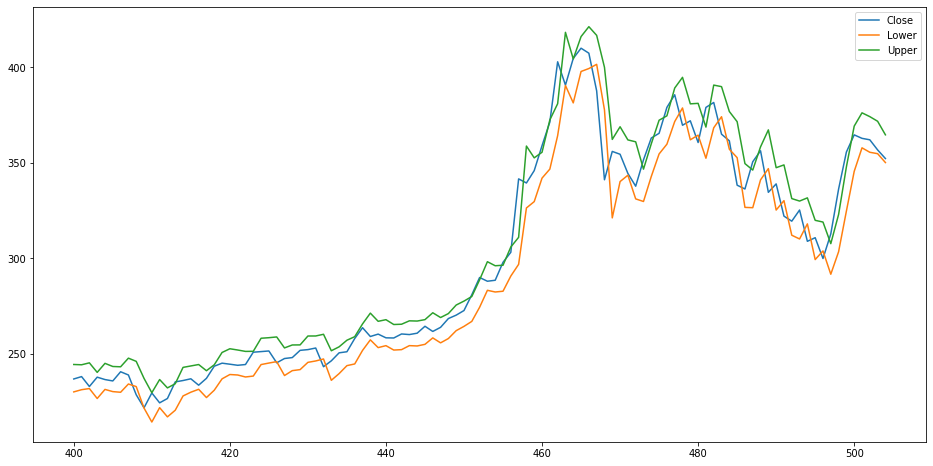

In [44]:
tesla_envelope_df[400:].plot()

If this is well calibrated the close should be within this envelope about as often the normal
distribution is within one standard deviation. That is about 68 percent. We will test that and also
about how often the closing price is within two standard deviations, which should be about 96
percent.



In [45]:
in_one_sd = (tesla_envelope_df['Upper'] > tesla_envelope_df['Close']) & (tesla_envelope_df['Lower'] < tesla_envelope_df['Close'])
print("Percentage within 1 standard deviation", in_one_sd.mean() * 100)

in_two_sd = (prediction1 - 2 * error_prediction < tesla_envelope_df['Close']) & (prediction1 + 2*error_prediction > tesla_envelope_df['Close'])

print("Percentage within two standard deviations", in_two_sd.mean() * 100)

Percentage within 1 standard deviation 77.22772277227723
Percentage within two standard deviations 94.05940594059405


To get a sense of how the prediction is working as a function of time, I am going to draw the
graph of a function that is 1 when the price is within one standard deviation and when it is not.

<AxesSubplot:>

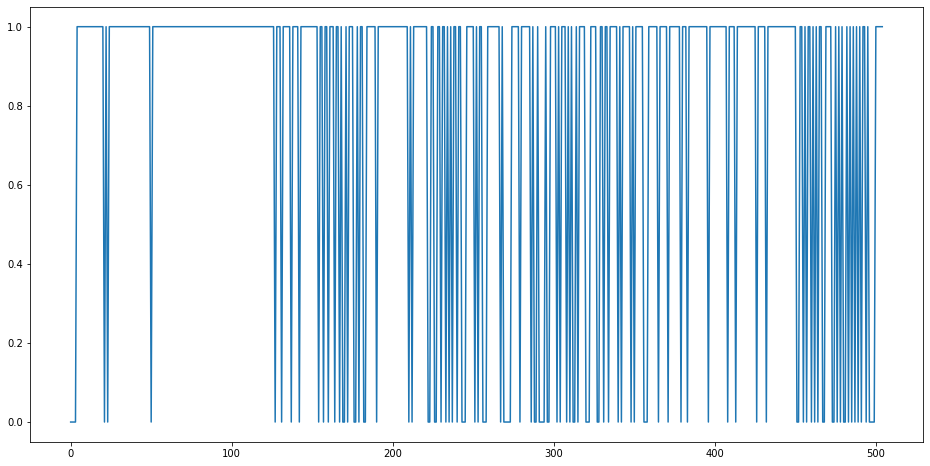

In [46]:
series = 1 * ((tesla_envelope_df['Upper'] > tesla_envelope_df['Close']) & (tesla_envelope_df['Lower'] < tesla_envelope_df['Close']))
series.plot()

# GARCH
[Notes](https://learn.london.ac.uk/pluginfile.php/265844/mod_resource/content/5/Topic%208%20Lecture%204%20GARCH.pdf)


Generalization of ARCH  




In [35]:
tesla_frame = yfinance.Ticker("TSLA").history(start='2020-01-01', end='2022-01-01', interval='1d').reset_index()['Close'].to_frame()

series = tesla_frame['Close']
ar_deg = 4

model = sm.tsa.AutoReg(series, lags=ar_deg, trend='n').fit()
prediction = model.predict()

tesla_frame['Prediction'] = prediction
error_sq = (series - prediction) ** 2
error_sq[error_sq.isna()] = 0

garch_model = sm.tsa.ARIMA(error_sq, order=(4,0,3), trend ='c').fit()
arch_model = sm.tsa.ARIMA(error_sq, order=(4,0,0), trend ='c').fit()

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


As before, we are going to use this to talk about a confidence interval of our predictions. Let’s do
both the ARCH and GARCH and compare.

In [36]:
garch_error_prediction = np.sqrt(garch_model.predict())
arch_error_prediction = np.sqrt(arch_model.predict())
tesla_garch_df = series.to_frame()
tesla_garch_df['Garch Lower'] = prediction - garch_error_prediction
tesla_garch_df['Garch Upper'] = prediction + garch_error_prediction
tesla_garch_df['Arch Lower'] = prediction - arch_error_prediction
tesla_garch_df['Arch Upper'] = prediction + arch_error_prediction
tesla_garch_df[100:110]

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Close,Garch Lower,Garch Upper,Arch Lower,Arch Upper
100,54.681999,50.286581,59.178438,48.300982,61.164037
101,53.720669,50.398443,59.102507,48.320320,61.180630
102,55.666668,49.517597,58.173322,47.401201,60.289718
103,59.873333,51.362428,60.132718,49.275183,62.219964
104,58.770668,55.383563,64.484605,53.289743,66.578425
105,58.863998,54.630402,63.546170,52.561835,65.614737
106,57.625332,54.951541,63.460639,52.753818,65.658363
107,59.043999,53.261884,62.114376,51.132744,64.243515
108,63.327999,54.495102,63.767717,52.662456,65.600362
109,62.711334,58.623444,68.114622,56.724154,70.013912


GARCH bounds tighter than ARCH ones

Look at the % out of hte bonds for both sets of prediction


In [37]:
in_one_sd = (tesla_garch_df['Garch Upper'] > tesla_garch_df['Close']) & (tesla_garch_df['Garch Lower'] < tesla_garch_df['Close'])
print("Percentage within 1 standard deviation", in_one_sd.mean() * 100)
in_two_sd = (prediction - 2 * garch_error_prediction < tesla_garch_df['Close']) & (prediction + 2 * garch_error_prediction > tesla_garch_df['Close'])
print("Percentage within two standard deviations", in_two_sd.mean() * 100)

Percentage within 1 standard deviation 74.05940594059406
Percentage within two standard deviations 93.46534653465348


In [38]:
in_one_sd = (tesla_garch_df['Arch Upper'] > tesla_garch_df['Close']) & (tesla_garch_df['Arch Lower'] < tesla_garch_df['Close'])
print("Percentage within 1 standard deviation", in_one_sd.mean() * 100)

in_two_sd = (prediction - 2 * arch_error_prediction < tesla_garch_df['Close']) & (prediction + 2 * arch_error_prediction > tesla_garch_df['Close'])
print("Percentage within two standard deviations", in_two_sd.mean() * 100)

Percentage within 1 standard deviation 77.02970297029704
Percentage within two standard deviations 94.05940594059405


It looks like it could be tighter still but it is good.  

We have looked at predicting error rates, assuming they vary. The two algorithms are parallel to AR and ARMA, working on squares of errors, rather than values of the series. 

You should now be able to use statsmodels to produce ARCH and GARCH models.

You should be able to see how well the percentages caught within one or two standard deviations of the prediction. 

In the next lesson, we are going to look more at likelihood calculations and their use in evaluations.